# Import libraries

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.cluster.hierarchy as hc
import scipy.spatial as sp

In [2]:
MAIN_DIR = Path('.').absolute().parent
sys.path.append(str(MAIN_DIR))
from dynosarc.dynamic import utils as utl
from dynosarc.dynamic import dynorc

# Directories and file names

In [3]:
DATA_DIR = MAIN_DIR / 'data'
RESULTS_DIR = MAIN_DIR / 'results'

In [4]:
SUBTYPES_FNAME = DATA_DIR / 'subtypes.csv'  

RNA_HPRD_FNAME = DATA_DIR / 'rna_hprd.csv'  
E_HPRD_ONCOKB_FNAME = DATA_DIR / 'edgelist_hprd_oncokb.csv' 

In [5]:
DYNO_RESULTS_DIR = RESULTS_DIR / 'dyno_results'

if not DYNO_RESULTS_DIR.is_dir():
    DYNO_RESULTS_DIR.mkdir()    

# Load data

In [6]:
subtypes = pd.read_csv(SUBTYPES_FNAME, header=0, index_col=0)
subtypes = subtypes['subtype']

In [7]:
lut = {'DSRCT': 'darkblue', 'Ewing Sarcoma': 'darkgreen', 'Osteosarcoma': 'orange', 'Embryonal RMS': 'purple'}
subtype_colors = subtypes.replace(lut).to_frame(name='Subtype')

In [8]:
# graph:
E_onco = pd.read_csv(E_HPRD_ONCOKB_FNAME, header=0, index_col=None)
G_onco = nx.from_pandas_edgelist(E_onco)
print(G_onco)

Graph with 675 nodes and 2667 edges


In [9]:
# RNA-Seq expression profiles:
data = pd.read_csv(RNA_HPRD_FNAME, header=0, index_col=0)
data = data[subtypes.index.copy()]

# Helper functions for dynamic analysis

In [10]:
def subtype_ids(subtypes, subtype):
    """ Return ids of samples in specified subtype
    
    Parameters
    -----------
    subtypes : Pandas Series
        Subtype classification for each sample.
    subtype : {'EWS', 'OST', 'DSRCT', 'ERMS'}
        Specify subtype.
        
    Return
    ------
    sids : list
        List of ids of samples in specified subtype.
    """        
        
    if subtype == 'EWS': 
        subtype = 'Ewing Sarcoma'
    elif subtype == 'OST':
        subtype = 'Osteosarcoma'
    elif subtype == 'ERMS':
        subtype = 'Embryonal RMS'
    elif subtype == 'DSRCT':
        pass
    else:
        raise ValueError("Unrecognized subtype, must be one of ['EWS', 'OST', 'DSRCT', 'ERMS'].")
            
    sids = subtypes.loc[subtypes==subtype].index.tolist()    
    return sids

In [11]:
def subtype_data(subtypes, subtype, return_copy=True):
    """ Return RNA expression profiles for samples in the specified subtype 
    
    Parameters
    -----------
    subtypes : Pandas Series
        Subtype classification for each sample.
    subtype : {'EWS', 'OST', 'DSRCT', 'ERMS'}
        Specify subtype.
    return_copy : bool
        If True, return copy of original data.
        
    Return
    ------
    data : Pandas DataFrame
        Subset of data for samples in specified cohort.
        """
    samples = subtype_ids(subtypes, subtype)
    gl = list(G_onco)
            
    if return_copy:
        return data.loc[gl, samples].copy()
    else:
        return data.loc[gl, samples]

In [12]:
def weighted_network(subtypes, subtype, **corr_kws):
    """ return subtype specific weighted network 
    
    Parameters
    -----------
    subtypes : Pandas Series
        Subtype classification for each sample.
    subtype : {'EWS', 'OST', 'DSRCT', 'ERMS'}
        Specify subtype.
    graph : {'onco', 'hprd'}
        Graph topology.
    corr_kws : dict
        Keyword arguments for computed weighted network.
        
    Returns
    -------
    s_weights : Pandas DataFrame
        Dataframe with 3 columns including source, target, weight of the network (where weights correspond to distance).
    """
    s_data = subtype_data(subtypes, subtype)
    edgelist = E_onco
            
    return utl.distance_weights(s_data, edgelist, **corr_kws)

In [13]:
file_ids = {"EWS": "ewing", "OST": "osteo", "DSRCT": "dsrct"}

def get_directory_prefix(subtype):            
    return "_".join([subtype, 'oncoKB', str(len(G_onco))])


def cohort_curvature_simulation(subtype, W, crit=0.75, directory=None,
                                force_recompute=False, chunksize=None, edgelist=None, **dyn_kws):
    """ load data and compute dynamic curvature analysis """
    
    if directory is None:
        directory = DYNO_RESULTS_DIR / get_directory_prefix(subtype)
    G = nx.from_pandas_edgelist(W, edge_attr='weight')
    dyno = utl.run_curvature_simulation(str(directory), G, crit=crit, chunksize=chunksize, edgelist=edgelist,
                                        force_recompute=force_recompute, **dyn_kws)
    return dyno
        
            
def get_cohort_curvature_simulation_results(subtype, crit=0.75, directory=None,
                                            **dyn_kws):
    """ load DORC simulation """   
    if directory is None:
        directory = DYNO_RESULTS_DIR / get_directory_prefix(subtype)    
    dyno = utl.load_curvature_simulation(str(directory), crit=crit, **dyn_kws)
    return dyno    

In [14]:
dyn_kws = dict(times=None, 
               t_min=-2.2,
               t_max=2.0, # 1.7
               n_t=55, # 50
               log_time=True,
               use_spectral_gap=False,
               e_weight="weight",
               verbose="INFO",
              )

# Dynamic curvature analysis

We demonstrate how to perform the dynamic curvature simulation on the EWS network

## Construct weighted network

In [15]:
subtype_cur = 'EWS'

In [16]:
data_cur = subtype_data(subtypes, subtype_cur)

corr_kws_cur = {'method': 'pearson', 
                'min_samples': data_cur.shape[1] - 3,       
                'thresh': 0.03, 
                'std_thresh': 3}

W_cur = weighted_network(subtypes, subtype_cur, **corr_kws_cur)

Desensitized correlation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 726.92it/s]


## Run dynamic simulation

In [17]:
# Only run once (load saved results next)
cohort_curvature_simulation(subtype_cur, W_cur, **dyn_kws)

## Load dynamic simulation resuls

In [18]:
dyno_cur = get_cohort_curvature_simulation_results(subtype_cur, crit=0.75, **dyn_kws)

## Critical curvature filter

In [19]:
G_sub = dyno_cur.G.copy()
G_sub.remove_edges_from([ee for ee, vl in nx.get_edge_attributes(dyno_cur.G, 'kappa_critical').items() if vl<0.0])

In [20]:
# size of remaining fucntionally associated network: 
print(G_sub)

Graph with 675 nodes and 1481 edges


In [21]:
# Remaining genes functionally associated with EWSR1, FLI1 and ETV6:

for gn in ['EWSR1', 'FLI1', 'ETV6']:
    gn_nbrs = [G_sub.nodes[k]['name'] for k in list(G_sub.neighbors(dyno_cur.get_node_index(gn)))]
    print(f"Functional neighbors of {gn}:", gn_nbrs)

Functional neighbors of EWSR1: ['MTCP1', 'FLI1', 'KEL', 'SERP2', 'YY1AP1']
Functional neighbors of FLI1: ['EWSR1', 'ETV6']
Functional neighbors of ETV6: ['FLI1']


## Multi-scale functional clustering

In [22]:
attr = 'wavg_kappa_critical'
cut_uniform=True
thresh_cut=0.0
mx_bump=0

cc_fname = str(Path(dyno_cur.directory) / f"CCrecord_{attr}_cut_uniform_{cut_uniform}_cut_start_{'negative' if thresh_cut<0 else '0'}.csv")
CCrecord_cur, CCdist_cur, linkage_cur = utl.community_hierarchy(dyno_cur.G,
                                                                         attr=attr,
                                                                         method='ward',
                                                                         optimal_ordering=True,
                                                                         cut_uniform=cut_uniform,
                                                                         thresh_cut=thresh_cut,
                                                                         mx_bump=0,
                                                                         cc_fname=cc_fname)

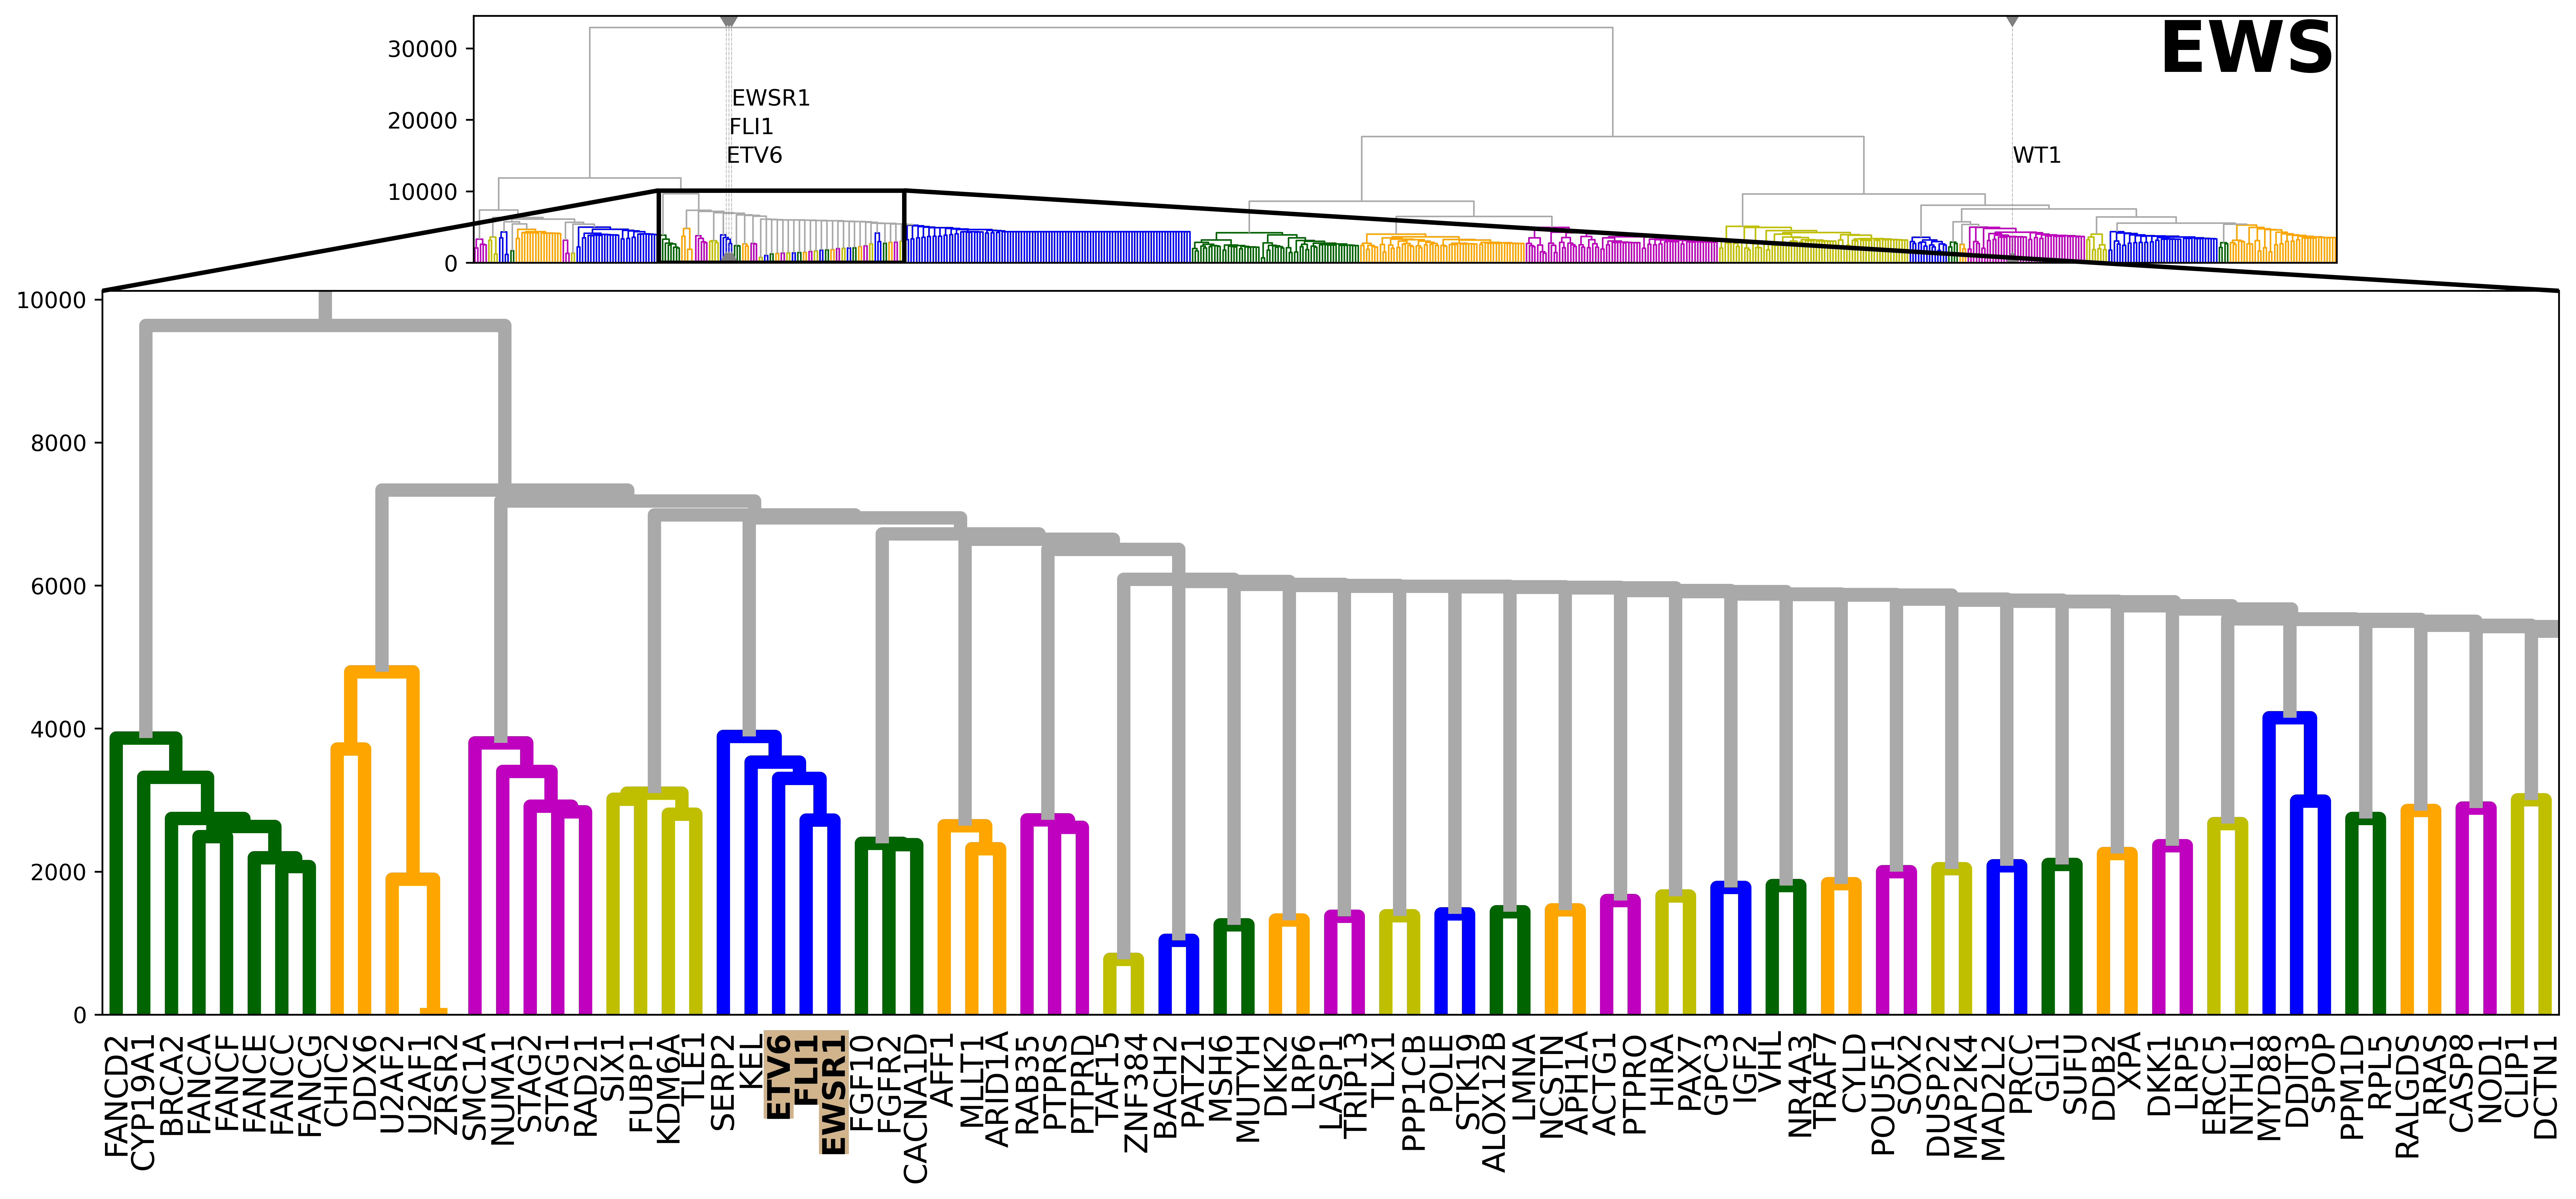

In [23]:
fig, ax = plt.subplots(figsize=(15, 2))

hc.set_link_color_palette(['m', 'y', 'b', 'darkgreen', 'orange'])
plt.rcParams['lines.linewidth'] = 0.7
nodes = hc.dendrogram(linkage_cur, ax=ax,
                      color_threshold=5300, 
                      above_threshold_color='darkgray',
                      get_leaves=True,
                      labels=[dyno_cur.G.nodes[k]['name'] for k in range(len(dyno_cur.G))],
                      no_labels=True,
                      # leaf_font_size=4,
                      count_sort='ascending',
                      distance_sort=False, 
                      no_plot=False,
                      show_leaf_counts=False,
                      leaf_rotation=90)

axins = zoomed_inset_axes(ax, 10, loc='lower center',                           
                          bbox_to_anchor=(-0.34, -3.09, 1.6, 0.3), bbox_transform=ax.transAxes)

plt.rcParams['lines.linewidth'] = 6
_ = hc.dendrogram(linkage_cur, ax=axins,
                      color_threshold=5300, 
                      above_threshold_color='darkgray',
                      get_leaves=True,
                      labels=[dyno_cur.G.nodes[k]['name'] for k in range(len(dyno_cur.G))],
                      leaf_font_size=14,
                      count_sort='ascending',
                      distance_sort=False, 
                      no_plot=False,
                      show_leaf_counts=False,
                      leaf_rotation=90)

# sub region of the original image
x1, x2, y1, y2 = 670., 1560, 0., 10120.0,
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

xlbls = axins.get_xmajorticklabels()
for lbl in xlbls:
    ll = lbl.get_text()
    if ll in ['EWSR1', 'FLI1', 'ETV6']: 
        lbl.set_fontweight('bold');
        lbl.set_bbox(dict(facecolor='tan', alpha=1., linewidth=0, pad=0.))

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, axins, loc1=1, loc2=2,
           fc="none", ec='k', lw=2, zorder=5)

ax.set_title(subtype_cur, fontsize=32, fontweight='bold', loc='right', y=0.72);

for gn in ['EWSR1', 'FLI1' ,'ETV6', 'WT1']:
    a = [k for k,i in enumerate(nodes['ivl']) if i==gn][0]
    xx = 5 + 10*a
    yy = 14000 if gn in ['WT1', 'ETV6'] else 18000 if gn=='FLI1' else 22000 
    ax.annotate(gn, xy=(xx, yy))
    ax.axvline(xx, c='gray', ls='-.', lw=0.2, marker='d');

# fig.dpi=600
# fig.savefig(MAIN_DIR / 'figures' / 'dyno_EWS_ms_persistent_clustering.png', 
#            dpi=300, bbox_inches='tight', bbox_extra_artists=(ax, axins))

plt.rcParams['lines.linewidth'] = 1.5  # return to matplotlib default line width 
hc.set_link_color_palette(None)  # reset to default after use          
